感谢大家来我的网站学习https://www.captainbed.net

我们先把上一篇文档的代码贴出来

In [24]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


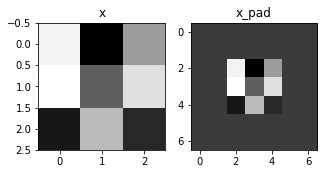

In [26]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_pad[1, 1] =", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [27]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W) + b

    Z = np.sum(s)

    return Z

In [28]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


In [29]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    Z = np.zeros((m, n_H, n_W, n_C))
 
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                                 
        a_prev_pad = A_prev_pad[i]                   
        for h in range(n_H):                         
            for w in range(n_W):                    
                for c in range(n_C): 
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
 
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [30]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


## 4 - 池化层

池化层可以将矩阵的尺寸变小。池化层不仅仅可以降低神经网络的计算量，还可以让网络的预测鲁棒性更好。

之前我给大家介绍了两种池化层: 

- 最大池化层（Max-pooling layer）: 取输入矩阵的子矩阵中的最大值元素作为输出矩阵的一个元素。

- 平均池化层（Average-pooling layer）: 取输入矩阵的子矩阵中的元素的平均值作为输出矩阵的一个元素。“子矩阵”在这里也被叫做“窗口”。

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

池化层是没有参数的，因为它的过滤器是虚拟的是不存在的。但是它有超参数，例如窗口大小f，也就是指定池化的子矩阵的高宽。 

### 4.1 - 池化的前向传播
下面我们实现了一个池化的前向传播函数，它可以指定用最大池化还是平均池化。

**提示**:
因为池化没有padding，所以计算输出矩阵的维度公式会与卷积层的有所不同:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [31]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    参数:
    A_prev -- 输入矩阵，也就是上一层的输出矩阵。维度是(m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- 超参数窗口大小f和步长s
    mode -- 池化模式,最大池化就写max，如果想用平均池化，就写average。
    
    返回值:
    A -- 池化层的输出矩阵，维度是(m, n_H, n_W, n_C)
    cache -- 缓存一些数据
    """

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"] # 窗口大小
    stride = hparameters["stride"] # 步长
    
    # 计算输出矩阵的尺寸大小
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # 初始化输出矩阵
    A = np.zeros((m, n_H, n_W, n_C))    
    
    for i in range(m):                           # 遍历所有样本
        for h in range(n_H):                     # 纵向遍历输出矩阵
            for w in range(n_W):                 # 横向遍历输出矩阵
                for c in range (n_C):            # 遍历输出矩阵的深度
                    
                    # 计算出输入矩阵中本次应该本池化的区域的索引，也就是本次的池化窗口的索引
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 通过上面的索引取出将被池化的子矩阵窗口
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # 执行池化
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice) # np.max就是numpy库中求最大值的函数
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)# 求平均值

    cache = (A_prev, hparameters)

    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


In [32]:
# 单元测试
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


至此，我们已经实现了CNN的所有前向传播操作。下面我们再来实现它的反向传播。

## 5 - CNN的反向传播

如果我们使用深度学习框架，例如Tensorflow，keras等等，我们只需要实现前向传播就可以了，因为框架会自动帮我们实现反向传播。因此，很多人工智能工程师都不需要关心反向传播的细节。

CNN的反向传播是比较复杂的。下面我也只是大概的介绍一下它。大家也就大致了解一下就可以了，看不懂也没有关系。

在我们之前学过的神经网络反向传播中，我们会通过计算成本函数相关的偏导数来不断更新参数w和b的值。其实在CNN的反向传播也是这个流程。在教程中我们没有列出CNN反向传播的相关公式，下面我会简单地给大家介绍一下它们。

### 5.1 - 卷积层的反向传播

首先我们来学习一下如何实现卷积层的反向传播。

#### 5.1.1 - 计算dA:
下面的公式被用来计算某个样本的某个过滤器的dA:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

$W_c$是表示这个过滤器。公式看不懂没关系！

这个公式对应的python代码如下：
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - 计算dW:
下面的公式被用来计算某个过滤器的dW:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

$a_{slice}$表示输入矩阵中的被卷积的子矩阵。

上面的公式对应于下面的python代码:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - 计算db:

这个公式用来计算某个过滤器的db:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

上面的公式对应于下面的python代码:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

In [33]:
def conv_backward(dZ, cache):
    """    
    参数:
    dZ -- 后一层相关的dZ，维度是(m, n_H, n_W, n_C)
    cache -- 前面的conv_forward()函数保存下来的缓存数据
    
    Returns:
    dA_prev -- 本卷积层输入矩阵的dA，维度是(m, n_H_prev, n_W_prev, n_C_prev)
    dW -- 本卷积层相关的dW,维度是(f, f, n_C_prev, n_C)
    db -- 本卷积层相关的db,维度是(1, 1, 1, n_C)
    """

    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"] # 步长
    pad = hparameters["pad"] # padding数量
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # 遍历每一个样本
        
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # 遍历输出矩阵的高
            for w in range(n_W):               # 遍历输出矩阵的宽
                for c in range(n_C):           # 遍历输出矩阵的深度
                    
                    # 计算输入矩阵中的子矩阵的索引
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # 取出当前进行卷积的子矩阵
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # 用上面的公式来计算偏导数
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [34]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))
# print(dA.shape)

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


## 5.2 池化层的反向传播

接下来我们实现一下池化层的反向传播。虽然池化层没有参数需要被更新，但是在编程时我们依然需要实现它的反向传播，这样才能继续计算在这个池化层前面的那些层的反向传播。

### 5.2.1 最大池化的反向传播

在实现池化层之前，我们需要先实现两个工具函数，第一个是 `create_mask_from_window()`，它可以根据输入矩阵得到一个特殊的输出矩阵，这个输出矩阵中只有最大值处是1，其余都是零。如下所示，X是输入矩阵，M是函数的输出矩阵: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

提示:
- [np.max()]()会返回矩阵中的最大元素。
- python语法`A = (X == x)`会生成一个矩阵A，这个A与X的维度是一样的，A里面其它元素都为0，只有与小x的值相同的位置处为1，也就是为True。python中0等于False，1等于True:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```

In [35]:
def create_mask_from_window(x):

    # x是一个矩阵。np.max(x)会得到最大元素。
    # mask是一个与x维度相同的矩阵，里面其余元素都为0，只有x最大值元素的位置处为1
    mask = x == np.max(x)
    
    return mask

In [36]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


### 5.2.2 - 平均池化的反向传播

为了实现最大池化的反向传播，我们需要实现如下的工具函数`distribute_value`。就是把一个数值平分成一个矩阵，例如把1平分成四分之一到一个矩阵中: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

In [37]:
def distribute_value(dz, shape):
    """    
    参数:
    dz -- 一个数值
    shape -- 输出矩阵的维度
    
    返回值:
    a -- a的维度就是shape，里面的值是又dz平分而来的
    """
    (n_H, n_W) = shape
    
    # 计算平均值
    average = dz / (n_H * n_W)
    
    # 构建输出矩阵
    a = np.ones(shape) * average
    
    return a

In [38]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


### 5.2.3 池化层的反向传播

接下来我们将上面的工具函数组合起来实现池化层的反向传播。

In [39]:

def pool_backward(dA, cache, mode = "max"):
    """
    参数:
    dA -- 本池化层的输出矩阵对应的偏导数
    cache -- 前向传播时缓存起来的数值
    mode -- 是最大池化还是平均池化，("max" 或 "average")
    
    Returns:
    dA_prev -- 本池化层的输入矩阵对应的偏导数
    """

    # A_prev是本池化层的输入矩阵
    (A_prev, hparameters) = cache
    
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                     
        a_prev = A_prev[i]
        for h in range(n_H):                  
            for w in range(n_W):             
                for c in range(n_C):          
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [40]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
